# 이진분류(Binary Classification) 위스콘신 유방암 데이터셋
- 이진 분류 문제 처리 모델의 2가지 방법
    1. positive(1)일 확률을 출력하도록 구현
        - out put layer : units = 1, activation = 'sigmoid'
        - loss = binary_crossentropy
    2. negative(0)일 확률과 postive(1)일 확률을 출력하도록 구현 / 다중분류 처리 방식으로 해결
        - outputlayer : units = 2, activation = 'softmax'
        - y정답은 one hot encoding 처리
        - loss : categorical_crossentropy

In [13]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
#1. 데이터 생성
input, output = load_breast_cancer(return_X_y=True)
input, output = input.astype("float32"), output.astype("float32")
output = output.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(input, output, stratify=output, test_size=0.2, random_state=0)

#2. y값 정의
classes = np.array(["악성종양", "양성종양"])
class_to_idx = {"악성종양" : 0, "양성종양" : 1}

#3. 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#4. 데이터 타입 변환 ndarray -> tensor
X_train_tensor = torch.tensor(X_train_scaled)
X_test_tensor = torch.tensor(X_test_scaled)
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

#5. Dataset 생성
trainset = TensorDataset(X_train_tensor,  y_train_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)

#6. DataLoader
train_loader = DataLoader(trainset, batch_size=200, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=len(testset))

#7. Model 정의
class BreastCancerModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(30, 32)
        self.lr2 = nn.Linear(32, 8)
        self.lr3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, X):
        out = self.relu(self.lr1(X))
        out = self.relu(self.lr2(out))
        out = self.lr3(out)
        out = self.sig(out)
        return out
    

#8. 학습 및 검증
import time

lr = 0.001
epochs = 1000
bc_model = BreastCancerModel().to(device)
loss_fn = nn.BCELoss() # 이진분류 loss함수
optimizer = optim.Adam(bc_model.parameters(), lr=lr)

save_path = "saved_models/breast_cancel_model.pth"
best_score = torch.inf
patience = 5
trigger_count = 0

train_loss_list = []
valid_loss_list = []
valid_acc_list = []
s = time.time()

for epoch in range(epochs):
    bc_model.train()
    train_loss = 0.0
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        pred_train = bc_model(X_train)
        loss = loss_fn(pred_train, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)

    bc_model.eval()
    valid_loss, valid_acc = 0.0, 0.0
    with torch.no_grad():
        for X_valid, y_valid in test_loader:
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            pred_valid = bc_model(X_valid) # positive일 확률값
            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item()
            predicted = (pred_valid > 0.5).float()
            valid_acc = valid_acc + (predicted == y_valid).float().mean().item()
        valid_loss = valid_loss / len(test_loader)
        valid_acc = valid_acc / len(test_loader.dataset)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        
    print(f"[{epoch+1}/{epochs}] train loss: {train_loss}, validation loss: {valid_loss}, validation accuracy: {valid_acc}")
    
    if valid_loss < best_score:
        print(f"{epoch + 1} epoch에 저장. best score : {best_score:.5f}가 {valid_loss:.5f}로 개선됨")
        best_score = valid_loss
        torch.save(bc_model, save_path)
        trigger_count = 0

    else:
        trigger_count += 1
        if patience == trigger_count:
            print(f"{epoch+1} epoch에서 조기 종료. {best_score:.5f}에서 개선되지 않음.")
            break

e = time.time()
print("걸린시간: ", e - s)






[1/1000] train loss: 0.65098637342453, validation loss: 0.6442543268203735, validation accuracy: 0.005540165984839724
1 epoch에 저장. best score : inf가 0.64425로 개선됨
[2/1000] train loss: 0.6398673951625824, validation loss: 0.635329008102417, validation accuracy: 0.005540165984839724
2 epoch에 저장. best score : 0.64425가 0.63533로 개선됨
[3/1000] train loss: 0.6353456079959869, validation loss: 0.6266964673995972, validation accuracy: 0.005540165984839724
3 epoch에 저장. best score : 0.63533가 0.62670로 개선됨
[4/1000] train loss: 0.6245071291923523, validation loss: 0.6180588603019714, validation accuracy: 0.005540165984839724
4 epoch에 저장. best score : 0.62670가 0.61806로 개선됨
[5/1000] train loss: 0.6136586666107178, validation loss: 0.6094743013381958, validation accuracy: 0.005540165984839724
5 epoch에 저장. best score : 0.61806가 0.60947로 개선됨
[6/1000] train loss: 0.6076394319534302, validation loss: 0.600799024105072, validation accuracy: 0.005540165984839724
6 epoch에 저장. best score : 0.60947가 0.60080로 개선됨


# 시각화

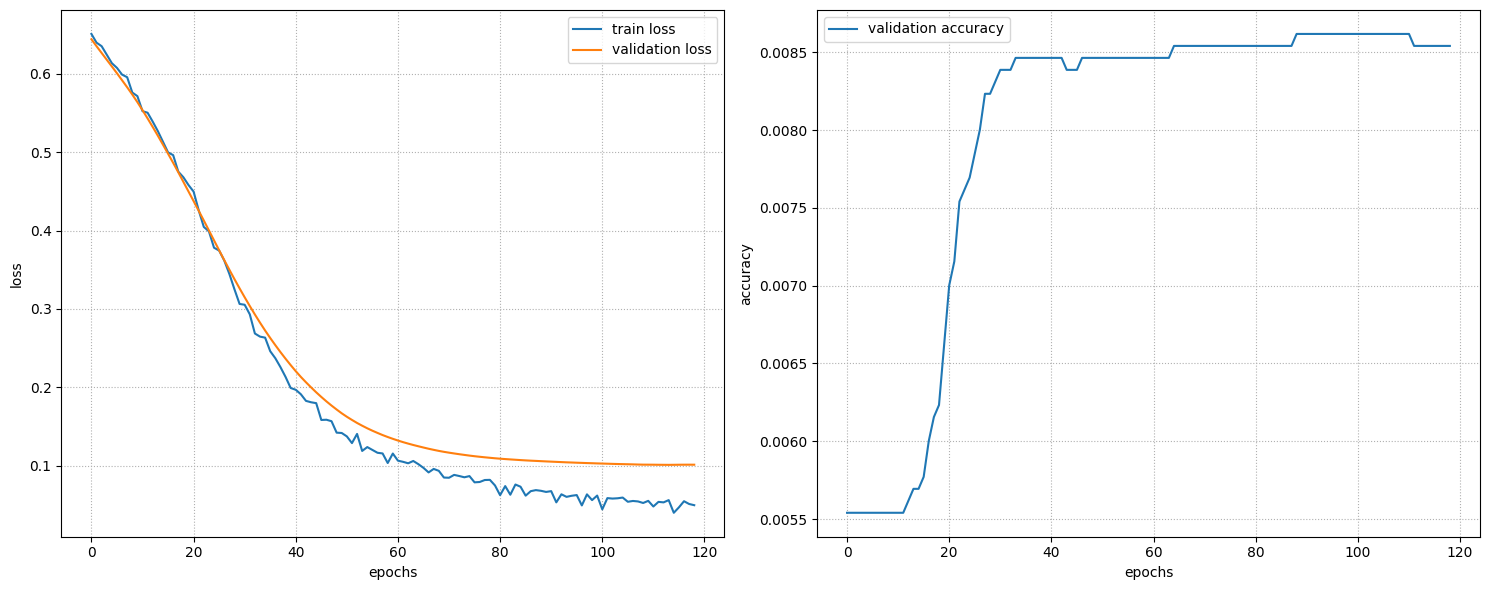

In [19]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
x = len(train_loss_list)
plt.plot(range(x), train_loss_list, label="train loss")
plt.plot(range(x), valid_loss_list, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True, linestyle=":")

plt.subplot(1, 2, 2)
plt.plot(range(x), valid_acc_list, label="validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True, linestyle=":")

plt.tight_layout()
plt.show()